In [34]:
%reload_ext autoreload
%autoreload 2

from IPython.display import HTML

import os
import itertools
import gc
import pickle
import random

import numpy as np
import pandas as pd
import pandas_summary as pds
import seaborn as sns
import xgboost as xgb

from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler, Normalizer, MinMaxScaler
# from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import keras
from keras import initializers
from keras.layers import Input, Embedding, Dense, Flatten, Dropout
from keras.models import Model
from keras.layers.merge import concatenate, multiply
from keras.layers.advanced_activations import LeakyReLU

from zillow import *
from utils import *

import matplotlib.pyplot as plt
%matplotlib inline

dl = DataLoader()
gc.collect()

13074

In [38]:
vals = describe_values(dl.get_properties())
cols_high_missing = set(vals.loc[vals['missing %'] > 50]['column'])
cols_high_missing

{'airconditioningtypeid',
 'architecturalstyletypeid',
 'basementsqft',
 'buildingclasstypeid',
 'buildingqualitytypeid',
 'decktypeid',
 'finishedfloor1squarefeet',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'finishedsquarefeet50',
 'finishedsquarefeet6',
 'fireplacecnt',
 'fireplaceflag',
 'garagecarcnt',
 'garagetotalsqft',
 'hashottuborspa',
 'heatingorsystemtypeid',
 'numberofstories',
 'poolcnt',
 'poolsizesum',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'propertyzoningdesc',
 'regionidneighborhood',
 'storytypeid',
 'taxdelinquencyflag',
 'taxdelinquencyyear',
 'threequarterbathnbr',
 'typeconstructiontypeid',
 'unitcnt',
 'yardbuildingsqft17',
 'yardbuildingsqft26'}

# Training & Testing w/ XGBoost

In [39]:
def remove_outliers(X, y):
    f = np.abs(y-y.mean())<=(3*y.std())
    return X[f], y[f]

def train_test_split(X, y, month=9):
    c = X.transaction_month
    return X[c < month], X[c == month], X[c > month], y[c < month], y[c == month], y[c > month]


def adapt_for_xgb(df):
    dropcols = set(['propertyzoningdesc', 
                'propertycountylandusecode', 
                'censustractandblock', 
                'rawcensustractandblock',
                'parcelid',
               ])
    dropcols = dropcols | cols_high_missing

    df = df.drop(dropcols, axis=1)
    for c in df.columns:
        if df[c].dtype.name == 'object':
            df[c] = df[c].replace('',0).astype(np.float32)
    
    return df

def xgb_train(params=None):
    train = dl.get_training_merged()
    train = adapt_for_xgb(train)
    
    X = train.drop(['logerror', 'logerror_abs'], axis=1)
    y = train['logerror']
    
    del train; gc.collect()
    
    x_train, x_valid, x_test, y_train, y_valid, y_test = train_test_split(X, y)
#     x_train, y_train = remove_outliers(x_train, y_train)

    d_train = xgb.DMatrix(x_train, label=y_train)
    d_valid = xgb.DMatrix(x_valid, label=y_valid)
    d_test = xgb.DMatrix(x_test, label=y_test)
    
    del x_train, x_valid, x_test; gc.collect()

    if not params:
        params = {
            'eta': 0.02,
            'objective': 'reg:linear',
            'eval_metric': 'mae',
#             'objective': 'binary:logistic',
#             'eval_metric': 'logloss',        
            'max_depth': 4,
            'silent': 1,
            'subsample': 0.75,
            'colsample_bytree': 0.6,
            'min_child_weight': 4,
            'lambda': 2,
#             'alpha': 1,
        }

    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    clf = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=100, verbose_eval=20)
    mae = mean_absolute_error(y_test, clf.predict(d_test))
    print ("Test MAE: ", mae)
    
    del d_train, d_valid, d_test; gc.collect()
    
    return clf


def xgb_predict(clf):
    # build the test set
    subm = pd.DataFrame()
    subm['ParcelId'] = dl.get_properties_preprocessed()['parcelid']
    months = [10, 11, 12, 22, 23, 24]
    dates = ['201610', '201611', '201612', '201710', '201711', '201712']
#     months = [10]
#     dates = ['201610']
    for month, date in zip(months, dates):
        print('Predicting...', date)

        merged = dl.get_prediction(month)
        merged = adapt_for_xgb(merged)
        gc.collect()
        
        dm_test = xgb.DMatrix(merged)
        del merged; gc.collect()
        
        subm[date] = clf.predict(dm_test)
        del dm_test; gc.collect()
    
    subm.to_csv('zillow/submission.csv.gz', index=False, float_format='%.4f', compression='gzip')
    return subm

    
def xgb_importance(clf):
    importance = clf.get_fscore()
    importance = sorted(importance.items(), key=lambda x: x[1])

    df = pd.DataFrame(importance, columns=['feature', 'fscore'])
    df['fscore'] = df['fscore'] / df['fscore'].sum()

    df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
    plt.title('XGBoost Feature Importance')
    plt.xlabel('relative importance');
    return df
    
# train a model
def train_predict(params=None, predict=False):
    clf = xgb_train(params)
    imp = xgb_importance(clf)
    subm = None
    if predict:
        subm = xgb_predict(clf)
    return clf, subm, imp

[0]	train-mae:0.495975	valid-mae:0.48973
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 100 rounds.
[20]	train-mae:0.450406	valid-mae:0.444202
[40]	train-mae:0.409306	valid-mae:0.403075
[60]	train-mae:0.372298	valid-mae:0.366029
[80]	train-mae:0.33896	valid-mae:0.332664
[100]	train-mae:0.309	valid-mae:0.302661
[120]	train-mae:0.28206	valid-mae:0.275729
[140]	train-mae:0.257921	valid-mae:0.251572
[160]	train-mae:0.236209	valid-mae:0.229933
[180]	train-mae:0.216745	valid-mae:0.21044
[200]	train-mae:0.199316	valid-mae:0.193062
[220]	train-mae:0.18375	valid-mae:0.177477
[240]	train-mae:0.169837	valid-mae:0.163529
[260]	train-mae:0.157452	valid-mae:0.151132
[280]	train-mae:0.146413	valid-mae:0.140098
[300]	train-mae:0.136584	valid-mae:0.130344
[320]	train-mae:0.127877	valid-mae:0.121706
[340]	train-mae:0.12017	valid-mae:0.114015
[360]	train-mae:0.113339	valid-mae:0.107259
[380]	train-mae:0.107358	valid-mae:

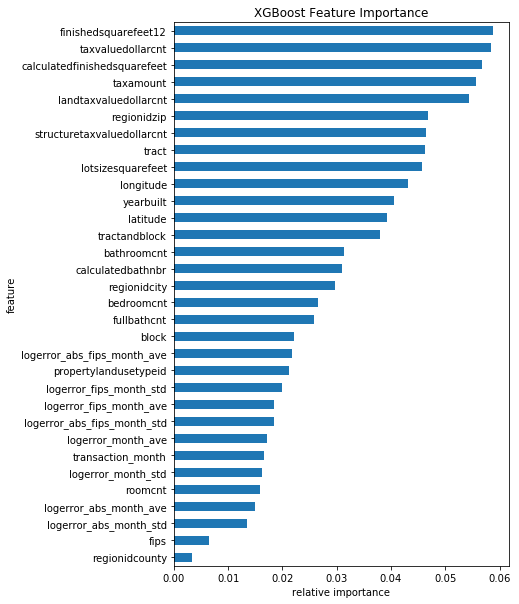

In [40]:
params = {
    'eta': 0.005,
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'max_depth': 3,
    'silent': 1,
    'subsample': 0.3,
    'colsample_bytree': 0.1,
    'min_child_weight': 4,
    'lambda': 2,
}

clf, subm, imp = train_predict(params=params, predict=False)

## Baseline MAE = 0.0653845034136

In [ ]:
from zillow import DataLoader

dl = DataLoader()
mrg = dl.get_training_merged()
gc.collect()

In [ ]:
cols = [c for c in mrg.columns if c.startswith('logerror')] + ['transaction_month', 'fips', 'parcelid']
describe_values(mrg.loc[:, cols])

In [ ]:
dl.logerror_month
plt.plot(dl.logerror_month['transaction_month'], dl.logerror_month['logerror_abs_month_ave'])

In [ ]:
dl.logerror_fips_month
for f in dl.logerror_fips_month['fips'].unique():
    df = dl.logerror_fips_month[dl.logerror_fips_month['fips'] == f]
    plt.plot(df['transaction_month'], df['logerror_abs_fips_month_ave'])

In [ ]:
from sklearn import linear_model
lm = linear_model.Ridge(alpha=0.5)

def forecast(df_train, df_preds, xcol, ycol):
    lm.fit(df_train.loc[:, [xcol]], df_train[ycol])
    df_preds[ycol] = lm.predict(df_preds.loc[:, [xcol]])
    return df_preds

df_train = dl.logerror_month.copy()
cols = list(df_train.columns)
cols.remove('transaction_month')
df_preds = pd.DataFrame([ m for m in range(13, 25) ], columns=['transaction_month'])
for c in cols:
    df_preds = forecast(df_train, df_preds, 'transaction_month', c)
display(df_preds)

In [ ]:
df_train = dl.logerror_fips_month.copy()
cols = list(df_train.columns)
cols.remove('transaction_month')
cols.remove('fips')
df_preds = pd.DataFrame()
for f in dl.logerror_fips_month['fips'].unique():
    df_fips = pd.DataFrame([ m for m in range(13, 25) ], columns=['transaction_month'])
    df_fips['fips'] = f
    for c in cols:
        df_fips = forecast(df_train[df_train['fips'] == f], df_fips, 'transaction_month', c)
    df_preds = df_preds.append(df_fips)
display(df_preds)

# Prepare Data Mappers

In [ ]:
procd = pd.read_pickle('zillow/preprocessed.pkl')

In [ ]:
# Let's do one more test with xgboost to see if everything is dandy.

dropcols = [
    'propertycountylandusecode',
    'propertyzoningdesc',
    'rawcensustractandblock',
    'censustractandblock',
]

df = procd.copy()
df.drop(dropcols, axis=1, inplace = True)
for c in df.columns:
    if df[c].dtype.name == 'object':
        df[c] = df[c].replace('',0).astype(np.float32)

_, _, imp = train_predict(df)

In [ ]:
display(imp)

In [ ]:
dropcols = set(imp.loc[imp.fscore < 0.001, 'feature'])
# dropcols.remove('transactiondate_month')
# dropcols.remove('age')
# dropcols.append('parcelid')

dropcols.update([
    'parcelid',
#     'propertycountylandusecode', 
    'propertyzoningdesc', 
    'censustractandblock',
    'rawcensustractandblock'])

dropcols = list(dropcols)
display(dropcols)

# dropcols = [
#     'parcelid',
#     'propertycountylandusecode', 
#     'propertyzoningdesc', 
#     'censustractandblock',
#     'rawcensustractandblock']

# cols = {
#     'parcelid',
#     'airconditioningtypeid', 
#     'architecturalstyletypeid', 
#     'basementsqft', 
#     'bathroomcnt', 
#     'bedroomcnt',
#     'buildingclasstypeid',
#     'buildingqualitytypeid',
#     'calculatedbathnbr',
#     'decktypeid': { 'fillna': 0, 'dtype': 'category' },
#     'finishedfloor1squarefeet': { 'fillna': 0, 'dtype': 'float32' },
#     'calculatedfinishedsquarefeet': { 'fillna': 0, 'dtype': 'float32' },
#     'finishedsquarefeet12': { 'fillna': 0, 'dtype': 'float32' },
#     'finishedsquarefeet13': { 'fillna': 0, 'dtype': 'float32' },
#     'finishedsquarefeet15': { 'fillna': 0, 'dtype': 'float32' },
#     'finishedsquarefeet50': { 'fillna': 0, 'dtype': 'float32' },
#     'finishedsquarefeet6': { 'fillna': 0, 'dtype': 'float32' },
#     'fips': { 'fillna': 0, 'dtype': 'category' },
#     'fireplacecnt': { 'fillna': 0, 'dtype': 'float32' },
#     'fullbathcnt': { 'fillna': 0, 'dtype': 'float32' },
#     'garagecarcnt': { 'fillna': 'median', 'dtype': 'float32' }, 
#     'garagetotalsqft', 
#     'hashottuborspa',
#     'heatingorsystemtypeid', 
#     'latitude', 
#     'longitude', 
#     'lotsizesquarefeet',
#     'poolcnt', 
#     'poolsizesum', 
#     'pooltypeid10', 
#     'pooltypeid2', 
#     'pooltypeid7',
#     'propertycountylandusecode', 
#     'propertylandusetypeid',
#     'propertyzoningdesc', 
#     'rawcensustractandblock', 
#     'regionidcity',
#     'regionidcounty', 
#     'regionidneighborhood', 
#     'regionidzip', 
#     'roomcnt',
#     'storytypeid', 
#     'threequarterbathnbr', 
#     'typeconstructiontypeid',
#     'unitcnt', 
#     'yardbuildingsqft17', 
#     'yardbuildingsqft26', 
#     'yearbuilt',
#     'numberofstories', 
#     'fireplaceflag', 
#     'structuretaxvaluedollarcnt',
#     'taxvaluedollarcnt', 
#     'assessmentyear', 
#     'landtaxvaluedollarcnt',
#     'taxamount', 
#     'taxdelinquencyflag', 
#     'taxdelinquencyyear',
#     'censustractandblock',
# }

In [ ]:
tx = 'transactiondate'

train = dl.get_training()
train = split_date(train, tx)
train = train.merge(procd, how='left', on='parcelid')
train = add_age(train)

gc.collect()

x = train.drop(['logerror', tx] + dropcols, axis=1)
# x['parcelid'] = x['parcelid'].astype(CATEGORY_TYPE)
# procd['parcelid'] = procd['parcelid'].astype(CATEGORY_TYPE)
y = train['logerror']

dte_cols = [ tx+'_year', tx+'_month', 'age']
cat_cols = [ c for c in x.columns if x[c].dtype.name == 'object' and c not in dte_cols ]
con_cols = [ c for c in x.columns if x[c].dtype.name != 'object' and c not in dte_cols ]

In [ ]:
dte_maps = [([c], StandardScaler(with_mean=False)) for c in dte_cols]
display(len(dte_maps))
cat_maps = [(c, LabelEncoder()) for c in cat_cols]
display(len(cat_maps))
con_maps = [([c], StandardScaler(with_mean=False)) for c in con_cols]
display(len(con_maps))

In [ ]:
dte_mapper = DataFrameMapper(dte_maps)
dte_map_fit = dte_mapper.fit(x)

In [ ]:
cat_mapper = DataFrameMapper(cat_maps)
cat_map_fit = cat_mapper.fit(procd)
# display(cat_map_fit.features)

In [ ]:
con_mapper = DataFrameMapper(con_maps)
con_map_fit = con_mapper.fit(x)
# display(con_map_fit.features)

In [ ]:
to_pickle(dte_map_fit, 'zillow/dte_maps.pkl')
to_pickle(cat_map_fit, 'zillow/cat_maps.pkl')
to_pickle(con_map_fit, 'zillow/con_maps.pkl')

In [ ]:
dte_map_fit = from_pickle('zillow/dte_maps.pkl')
cat_map_fit = from_pickle('zillow/cat_maps.pkl')
con_map_fit = from_pickle('zillow/con_maps.pkl')

# Build the NN Model

In [ ]:
embsz = 16

def categorical_input(fname, fclasses):
    vocsz = len(fclasses)
#     print(vocsz)
    inp = Input((1,), dtype='int64', name=fname+'_inp')
    out = Embedding(vocsz, embsz, input_length=1, embeddings_initializer='random_uniform')(inp)
    out = Flatten(name=fname+'_flt')(out)
    if fname == 'parcelid':
        out = Dropout(0.9)(out)
    out = Dense(1, name=fname+'_den', activation='relu')(out)
    return inp, out

def continuous_input(fname):
    inp = Input((1,), dtype='float32', name=fname+'_inp')
    out = Dense(1, name=fname+'_den', activation='relu')(inp)
    return inp, out    

cat_in = [ categorical_input(f[0], f[1].classes_) for f in cat_map_fit.features ]
con_in = [ continuous_input(f[0][0]) for f in con_map_fit.features ] +\
[ continuous_input(f[0][0]) for f in dte_map_fit.features ]

den = concatenate([ o for _, o in cat_in ] + [ o for _, o in con_in ])
den = Dropout(0.05)(den)
den = Dense(256, activation=LeakyReLU(), kernel_initializer='random_uniform')(den)
den = Dense(256, activation=LeakyReLU(), kernel_initializer='random_uniform')(den)
den = Dense(1, activation='softplus')(den)
den = Dense(1, activation='linear')(den)
# out = multiply([tanh, relu])

model = Model(inputs=[ i for i, _ in cat_in ] + [ i for i, _ in con_in ], outputs=[den])
model.compile('adam', 'mean_absolute_error')
model.summary()

In [ ]:
def transform(df, mappers):
    mapped = []
    for m, dtype in mappers:
        mapped.append(m.transform(df).astype(dtype))
    return np.concatenate(mapped, axis=1)

def split(df):
    return np.split(df, df.shape[1], axis=1)

In [ ]:
mappers = [(cat_map_fit, 'int64'), (con_map_fit, 'float32'), (dte_map_fit, 'float32')]

x_train = transform(x, mappers)
x_train = split(x_train)

y_train = y

In [ ]:
hist = model.fit(x_train, y_train, batch_size=256, epochs=5, verbose=1, validation_split=0.1, shuffle=True)

# Use a small sample for testing the NN

In [ ]:
# get a sample
x_train, x_valid, x_test, y_train, y_valid, y_test = train_test_split(x, y, 2)

In [ ]:
mappers = [(cat_map_fit, 'int64'), (con_map_fit, 'float32'), (dte_map_fit, 'float32')]

x_train = transform(x_train, mappers)
x_valid = transform(x_valid, mappers)
x_test = transform(x_test, mappers)

x_train = split(x_train)
x_valid = split(x_valid)
x_test = split(x_test)

gc.collect()

In [ ]:
to_pickle(x_train, 'zillow/x_train.pkl')
to_pickle(x_valid, 'zillow/x_valid.pkl')
to_pickle(x_test, 'zillow/x_test.pkl')

to_pickle(y_train, 'zillow/y_train.pkl')
to_pickle(y_valid, 'zillow/y_valid.pkl')
to_pickle(y_test, 'zillow/y_test.pkl')

In [ ]:
x_train = from_pickle('zillow/x_train.pkl')
x_valid = from_pickle('zillow/x_valid.pkl')
x_test = from_pickle('zillow/x_test.pkl')

y_train = from_pickle('zillow/y_train.pkl')
y_valid = from_pickle('zillow/y_valid.pkl')
y_test = from_pickle('zillow/y_test.pkl')

In [ ]:
hist = model.fit(x_train, y_train, batch_size=128, epochs=1,
                 verbose=1, validation_data=(x_valid, y_valid))

In [ ]:
mae = mean_absolute_error(y_test, model.predict(x_test))
display(mae)

In [ ]:
# build the test set
sample = dl.get_submission()

subm = pd.DataFrame()
subm['ParcelId'] = sample['ParcelId']

tx = 'transactiondate'
# build a set to do predict on
test = pd.DataFrame()
test['parcelid'] = sample['ParcelId']
test = test.merge(procd, on='parcelid', how='left')
test = test.drop(dropcols, axis=1)

# we transform all the cols but without the dates
mappers = [(cat_map_fit, 'int64'), (con_map_fit, 'float32')]
test = transform(test, mappers)

In [ ]:
display(sample.shape)
display(test.shape)

In [ ]:
# dates = pd.date_range('2016-10-01', '2016-12-31').append(pd.date_range('2017-10-01', '2017-12-31'))
dates = pd.to_datetime(['2016-10-01', '2016-11-01', '2016-12-01', '2017-10-01', '2017-11-01', '2017-12-01'])
for date in dates:
    batch = pd.DataFrame()
    batch['parcelid'] = sample['ParcelId']
    batch[tx] = date
    batch = split_date(batch, tx)
    batch = add_age(batch).drop(['parcelid', tx], axis=1)
    batch = transform(batch, [(dte_map_fit, 'float32')])
    batch = np.concatenate((test, batch), axis=1)
    batch = split(batch)
    
    print('Predicting...', date)
    subm['{}{}'.format(date.year, date.month)] = model.predict(batch, verbose=1)
    display(subm)
    del batch; gc.collect()

# subm = subm.groupby(['parcelid', tx+'_year', tx+'_month']).mean()
# subm = subm.pivot_table(index='parcelid', columns=['transactiondate_year', 'transactiondate_month'], values='logerror')
# cols = ["{}{}".format(*c) for c in subm.columns]
# subm.reset_index(inplace=True)
# subm.columns = ['ParcelId'] + cols
display(subm)
subm.to_csv('zillow/submission.csv.gz', index=False, float_format='%.4f', compression='gzip')

# EDA

## Training, Properties and Submission Data

In [ ]:
dv = describe_values(dl.get_properties())

In [ ]:
dv[dv['missing %'] < 50]

In [ ]:
tx = 'transactiondate'
train = dl.get_training()
train = split_date(train, tx).drop(tx, axis=1)
train = train.pivot_table(columns='parcelid', index=['transactiondate_year', 'transactiondate_month'], values='logerror')
display(train)

In [ ]:
# how much data is missing?
display(train.isnull().sum().sum() / (train.shape[0]*train.shape[1]))

Most parcels have only 1 data point. Too much missing data to be useful on a per parcel basis.

In [ ]:
prop_parcels = set(dl.get_properties()['parcelid'])
subm_parcels = set(dl.get_submission()['ParcelId'])
trxn_parcels = set(dl.get_training()['parcelid'])
prp = dl.get_properties()
nodt_parcels = set(prp.loc[prp.rawcensustractandblock.isnull(), 'parcelid'])

# Are all properties required in the submission?
display(len(prop_parcels - subm_parcels) == 0)

# Do all properties have recorded transactions?
display(len(prop_parcels - trxn_parcels) == 0)

# How much of the submission is missing?
display(len(subm_parcels - trxn_parcels))

print(len(nodt_parcels & trxn_parcels), 'parcels have no data but have transactions')

Also some parcels have no property data!

## Logerror

In [ ]:
# check for outliers
pd.DataFrame(dl.get_training()['logerror']).plot.scatter(x='logerror', y='logerror')

In [ ]:
summarize(pd.DataFrame(dl.get_training()['logerror']))

In [ ]:
# see if logerror varies per month

tx = 'transactiondate'
txm = tx+'_month'
df = split_date(dl.get_training(), tx).merge(dl.get_properties(), how='left', on='parcelid')
df = add_age(df)
df = split_census(df)
df['abs_logerror'] = df['logerror'].abs()
# f, axes = plt.subplots(4, 3, sharey=True, sharex=True, figsize=(20, 20))
# for axis, (idx, df) in zip(itertools.chain(*axes), df_train):
#     axis.set(yscale="log")
#     display(axis)
#     display(df_train)
#     sns.distplot(df['logerror'], color="m", ax=axis).set_title(idx)

In [ ]:
monthly = df[[txm, 'logerror']].groupby([txm])['logerror'].mean()
plt.plot(monthly.index, monthly)

In [ ]:
monthly = df[[txm, 'abs_logerror']].groupby([txm])['abs_logerror'].mean()
plt.ylim(0.06, 0.08)
plt.plot(monthly.index, monthly)

In [ ]:
def plot_monthly(df, grp, val):
    monthly = df.groupby([grp, txm])[val].mean()
    figs = len(monthly.index.levels[0])
    f, axes = plt.subplots(figs, 1, figsize=(8, figs*4), sharex=True, sharey=True)
    for g, ax in zip(monthly.index.levels[0], axes):
        plt.subplot(ax)
        plt.plot(monthly[g].index, monthly[g])

In [ ]:
plot_monthly(df, 'fips', 'logerror')

In [ ]:
plot_monthly(df, 'fips', 'abs_logerror')

In [ ]:
plot_monthly(df, 'regionidcounty', 'abs_logerror')

In [ ]:
monthly = df[[txm, 'abs_logerror']].groupby([txm])['abs_logerror'].mean()
monthly = monthly.reset_index()

In [ ]:
from sklearn import linear_model
reg = linear_model.Ridge(alpha = .5)
reg.fit(monthly.drop('abs_logerror', axis=1), monthly['abs_logerror'])
preds = pd.DataFrame([ i for i in range(24)])
preds['abs_logerror'] = reg.predict(preds)

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(monthly.index, monthly['abs_logerror'])
plt.plot(preds.index, preds['abs_logerror'])

In [ ]:
sns.lmplot(x=txm, y="abs_logerror", data=monthly, ci=None, palette="muted")

In [ ]:
from sklearn import linear_model
lm = linear_model.Ridge(alpha = .5)

def regress(df, val):
    monthly = df.groupby(['fips', 'age'])[val].mean()
    preds = pd.DataFrame()
    for f in monthly.index.levels[0]:
        fip = monthly[f].reset_index()
        lm.fit(fip.drop(val, axis=1), fip[val])
        next_months = pd.DataFrame([ i for i in range(13, 25)], columns=['age'])
        next_months[val] = lm.predict(next_months)
        next_months['fips'] = f
#         display(next_months)
        preds = preds.append(next_months)
    preds = preds.append(monthly.reset_index())
    display(preds)

regress(df, 'abs_logerror')